In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2

In [2]:
from config import cfg
cfg.SEQ_LENGTH = 250
cfg.TILE_SIZE = (16,16)
cfg.OUT_SIZE = (1,1)
cfg.TRAIN.EPOCH = 0
cfg.TRAIN.EPOCH_NUM = 1000
cfg.gm_num = 7
cfg.ndim = 12
cfg.NAME = 'conv_net_no_bn_ndim%d_gm_num%d_'%(cfg.ndim ,cfg.gm_num)

In [3]:
from loader import TieLoader,GMMDataLoader,draw_sample
train_loader = GMMDataLoader(TieLoader('/media/data/Programming/motion_segmentation/gmm_segmentation/ties256',
                                    cols=16,rows=16,t_size=48),\
                           cfg.TILE_SIZE,cfg.OUT_SIZE,cfg.SEQ_LENGTH,min_r=0.1,max_r=0.3)

(250, 3, 16, 16)


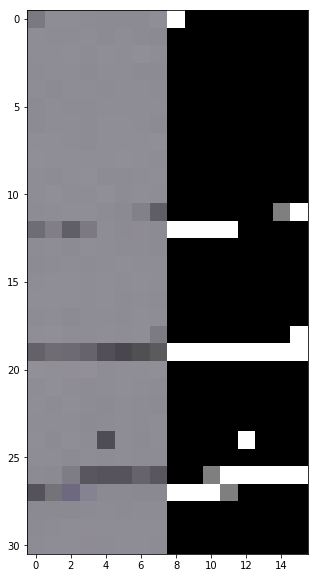

In [4]:
def data_generator(gmm_loader,
                   tile_size = cfg.TILE_SIZE,
                   epoch_size = cfg.TRAIN.EPOCH_SIZE):
    iter = 0
    for i in range(epoch_size):        
        yield gmm_loader.load_random()
        
for x,y in data_generator(train_loader,epoch_size=1):
    print x.shape
    draw_sample(x,y,8,cfg.SEQ_LENGTH//8)
    break

In [5]:
import theano
import theano.tensor as T

Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GT 740M (0000:01:00.0)


# Build model

In [6]:
from utils import get_network_str,save_weights,load_weights
import lasagne
from lasagne import layers as L
from lasagne.nonlinearities import rectify
from theano_utils import histogram_loss
from lasagne.regularization import regularize_network_params,l2
from gmm_op import get_gmm,calc_log_prob_gmm,calc_log_prob_gmm_componetwise
from theano_utils import split

data = T.tensor4(name='data')
label = T.tensor3(name='label')

def FCN(data,ndim=cfg.ndim,verbose=True,model_name=''):
    res = L.InputLayer((None,3,None,None)
                           ,data
                           ,name='data')
    res = L.Conv2DLayer(res,filter_size=(3,3),num_filters=6,
                        nonlinearity=rectify,pad='same',
                        name='conv1')
    res = L.Conv2DLayer(res,filter_size=(3,3),num_filters=12,
                        nonlinearity=rectify,pad='same',
                        name='conv2')
    res = L.Conv2DLayer(res,filter_size=(3,3),num_filters=ndim,
                        nonlinearity=None,pad='same',
                        name='conv3')
    if(model_name != ''):
        load_weights(res,model_name)
    print get_network_str(res,incomings=True,outgoings=True)
    sym = lasagne.layers.get_output(res)
    sym = T.transpose(sym,(0,2,3,1))
    sym = sym/(T.sqrt(T.square(sym).sum(-1)+1e-8)[:,:,:,None])
    params = lasagne.layers.get_all_params(res, trainable=True)
    l2_loss = 1e-4 * regularize_network_params(res, l2)
    return res,sym,params,l2_loss
               

def soft_predict_sym(features,means,covars,weights):
    return 1.-T.nnet.sigmoid(calc_log_prob_gmm(features,means,covars,weights))


# Train

In [7]:
def get_output(X,t_size=cfg.TILE_SIZE,o_size=cfg.OUT_SIZE):
    return X[:,:,(t_size[1]-o_size[1])//2:(t_size[1]+o_size[1])//2,\
              (t_size[0]-o_size[0])//2:(t_size[0]+o_size[0])//2]


def make_train_fn(model_name=''):
    def split_tr_p_n(x,y):
        x_tr_p,x_n = split(x,y)
        x_p = x_tr_p[-x_n.shape[0]:]
        x_tr = x_tr_p[:-x_n.shape[0]]
        return x_tr,x_p,x_n
    
    data = T.tensor4(name='data')
    label = T.tensor3(name='label')
    net,X,params,l2_loss = FCN(data,ndim=cfg.ndim,model_name=model_name)
    X = X[:,X.shape[1]//2:X.shape[1]//2+1,X.shape[2]//2:X.shape[2]//2+1,:]
    X = X.reshape((-1,X.shape[-1]))
    x_tr,x_p,x_n = split_tr_p_n(X,label.flatten())
    m,c,w = get_gmm(x_tr,cfg.gm_num,cfg.ndim)
    p_n = calc_log_prob_gmm(x_n,m,c,w)
    p_p = calc_log_prob_gmm(x_p,m,c,w)
    loss = histogram_loss(p_n,p_p,1e-4,100)[0]+l2_loss
    prediction = T.nnet.sigmoid(T.concatenate([p_p,p_n],axis=0))
    Y = T.concatenate([T.ones_like(p_p),T.zeros_like(p_n)],axis=0)
    G_lr = theano.shared(np.array(0.001, dtype=theano.config.floatX))
    updates = lasagne.updates.adam(loss,params,G_lr)
    train_fn = theano.function([data, label], [loss,X,Y,prediction,m,c,w],\
                               allow_input_downcast=True, updates=updates)
    print 'train_fn compiled'
    return train_fn,G_lr,net

train_fn,G_lr,net=make_train_fn()


In -->     Layer    --> Out    Description                
-------    -----    -------    -----------                
[]         0        [1]        data(None, 3, None, None)  
[0]        1        [2]        conv1(None, 6, None, None) 
[1]        2        [3]        conv2(None, 12, None, None)
[2]        3        []         conv3(None, 24, None, None)
train_fn compiled


In [8]:
G_lr.set_value(np.float32(0.001))

In [9]:
from sklearn.metrics import average_precision_score
def train_net(train_fn,train_loader,net,epoch_size=100,num_epochs = 15,with_hnm=False):
    hard = []
    cur = 0
    models_acc = []
    for j in range(0,num_epochs):
        train_loss=0
        train_acc=0
        for i,batch in enumerate(data_generator(train_loader,epoch_size=epoch_size)):
            res = train_fn(*batch)
            acc = average_precision_score(res[2],res[3])
            train_acc +=acc
            train_loss+=res[0]
            if(with_hnm):
                if(res[0] > 10):
                    if( len(hard) < 1000):
                        hard.append(batch)
                    else:
                        hard[cur] = batch
                        cur = (cur+1) % len(hard)
                for k in range(min(3,len(hard))):
                    batch = hard[np.random.randint(0,len(hard))]
                    res = train_fn(*batch)
            print '\r epoch %i batch %i loss=%.2f ,acc=%.2f l=%.2f a=%.2f'%(j,i,train_loss/float(i+1),train_acc/float(i+1),res[0],acc),
        print ''
        models_acc.append(acc)
        save_weights(net,'models/%s%03d'%(cfg.NAME,j))
        if(j == 50):
            G_lr.set_value(np.float32(0.0001))
        print ''
    return models_acc

In [10]:

models_acc = []
for j in range(0,15):
    train_loss=0
    train_acc=0
    for i,batch in enumerate(data_generator(train_loader,epoch_size=100)):
        res = train_fn(*batch)
        acc = average_precision_score(res[2],res[3])
        train_acc +=acc
        train_loss+=res[0]
#         if(res[1] < .8):
#             if( len(hard) < 1000):
#                 hard.append(batch)
#             else:
#                 hard[cur] = batch
#                 cur = (cur+1) % len(hard)
#         for k in range(min(3,len(hard))):
#             batch = hard[np.random.randint(0,len(hard))]
#             res = train_fn(*batch)
        print '\r epoch %i batch %i loss=%.2f ,acc=%.2f l=%.2f a=%.2f'%(j,i,train_loss/float(i+1),train_acc/float(i+1),res[0],acc),
    print ''
    models_acc.append(acc)
    save_weights(net,'models/%s%03d'%(cfg.NAME,j))
    if(j == 50):
        G_lr.set_value(np.float32(0.0001))
    print ''

 epoch 0 batch 99 loss=329.33 ,acc=0.92 l=50.69 a=0.94 0                                                                                                   
checkpoint models/conv_net_no_bn_ndim24_gm_num4_000.npz

 epoch 1 batch 99 loss=259.86 ,acc=0.89 l=92.28 a=0.78 1                                                                                              
checkpoint models/conv_net_no_bn_ndim24_gm_num4_001.npz

 epoch 2 batch 99 loss=253.12 ,acc=0.89 l=82.93 a=0.89 6                                                                                                 
checkpoint models/conv_net_no_bn_ndim24_gm_num4_002.npz

 epoch 3 batch 99 loss=270.74 ,acc=0.85 l=0.00 a=0.82 44                                                                                                
checkpoint models/conv_net_no_bn_ndim24_gm_num4_003.npz

 epoch 4 batch 99 loss=134.59 ,acc=0.84 l=28.20 a=0.78 8                                                                                                
check

# Evaluate model

In [11]:
from test_tools import iretate_test_dataset,make_features,make_gmms,fit_gmms,predict_pixelwise
from sklearn import mixture

def make_test(feature_fn,predict_fn,out_dir='results/'+cfg.NAME,dataset='dataset',max_frames=300,im_size = (320//2,240//2)):
    for folder,imgs,masks in iretate_test_dataset(out_dir,dataset,max_frames,im_size):        
        print folder,'generate_features,',
        data = make_features(feature_fn,imgs)
        gmms = make_gmms(imgs.shape[1:-1],cfg.gm_num)
        print 'fit gmms,',
        fit_gmms(data[:100],gmms,masks[:100])
        print 'predict,',
        prediction = predict_pixelwise(data[100:],gmms,predict_fn)
        print 'save'
        imgs = imgs[100:]
        masks = masks[100:]      
        prediction = (prediction*255).astype(np.uint8)
        for i in range(len(imgs)):
            cv2.imwrite(folder+'/'+str(i)+'.png',prediction[i])
            cv2.imwrite(folder+'/'+str(i)+'_true.png',masks[i])
            cv2.imwrite(folder+'/'+str(i)+'_input.jpg',imgs[i])
    print 'test complete'

In [12]:
data=T.tensor4()
feature_sym = FCN(data,model_name='models/%s%03d'%(cfg.NAME,np.array(models_acc).argmax()))[1]
feature_fn = theano.function([data],feature_sym,allow_input_downcast=True)


In -->     Layer    --> Out    Description                
-------    -----    -------    -----------                
[]         0        [1]        data(None, 3, None, None)  
[0]        1        [2]        conv1(None, 6, None, None) 
[1]        2        [3]        conv2(None, 12, None, None)
[2]        3        []         conv3(None, 24, None, None)


In [13]:
data,m,c,w=T.matrix(),T.matrix(),T.matrix(),T.vector()
predict_fn = theano.function([data,m,c,w],soft_predict_sym(data,m,c,w),allow_input_downcast=True)

In [14]:
make_test(feature_fn,predict_fn)

results/conv_net_no_bn_ndim24_gm_num4_/badWeather/blizzard generate_features, fit gmms, predict, save
results/conv_net_no_bn_ndim24_gm_num4_/baseline/highway generate_features, fit gmms, predict, save
results/conv_net_no_bn_ndim24_gm_num4_/cameraJitter/badminton generate_features, fit gmms, predict, save
results/conv_net_no_bn_ndim24_gm_num4_/dynamicBackground/boats generate_features, fit gmms, predict, save
results/conv_net_no_bn_ndim24_gm_num4_/shadow/backdoor generate_features, fit gmms, predict, save
results/conv_net_no_bn_ndim24_gm_num4_/thermal/corridor generate_features, fit gmms, predict, save
test complete


# Calc metric

In [15]:
from sklearn.metrics import average_precision_score
import os


def calc_metrics_imgs(predict,label):
    predict,label = predict.flatten(),label.flatten()
    mask = (label>230)|(label < 50)
    p = (predict.astype(np.float32)/255.)[mask]
    y = (label.astype(np.float32)/255.)[mask]
    y[y>0.5] = 1.
    y[y<=0.5] = 0.
    bp = np.zeros_like(p)
    bp[p>0.5] = 1.
    TP = (bp*y).sum()
    TN = ((1-bp)*(1-y)).sum()
    FP = (bp*(1.0-y)).sum()
    FN = ((1.0-bp)*y).sum()
    results = dict( AveragePrecision = average_precision_score(y,p),\
                    Recall = TP / (TP + FN),\
                    Sp = TN / (TN + FP),\
                    FPR = FP / (FP + TN),\
                    FNR = FN / (TP + FN),\
                    PWC =  100 * (FN + FP) / (TP + FN + FP + TN),\
                    F_Measure  =  (2 * (TP / (TP + FP)) * (TP / (TP + FN))) / (TP / (TP + FP) +  TP / (TP + FN)),\
                    Precision  = TP / (TP + FP))
    
    return results

def print_results(results):
    s = ''
    for k in results.keys():
        s=s+k+str(': ')+str(results[k])+'\n'
    return s

def calc_metrics_folder(data_dir):
    pred = []
    masks = []
    for i in range(1000):
        m = cv2.imread(data_dir+'/%i_true.png'%(j))
        p = cv2.imread(data_dir+'/%i.png'%(j))
        if not (p is None):
            pred.append(p)
            masks.append(m)
        else:
            break
    if(len(pred)>0):
        pred = np.array(pred)
        masks = np.array(masks)
        res = calc_metrics_imgs(pred,masks)
        print data_dir
        print print_results(res)
        return res
    return None

def calc_metric_all_folders(data_dir):
    res = []
    f = open('results/'+cfg.NAME+'.txt','w')
    for j in os.listdir(data_dir):
        folder = data_dir+'/'+j+'/'+os.listdir(data_dir+'/'+j)[0]
        results = calc_metrics_folder(folder)
        if not (results is None):
            res.append(results)
            f.write(folder+'\n')
            f.write(print_results(results))
    results = dict()
    for k in res[0].keys():
        results[k] = np.array([i[k] for i in res]).mean()
    f.write('total result\n')
    f.write(print_results(results))
    f.close()
    print 'total result'
    print print_results(results)

calc_metric_all_folders('results/'+cfg.NAME)

results/conv_net_no_bn_ndim24_gm_num4_/badWeather/blizzard
AveragePrecision: 0.443179853116
FNR: 0.715517
Recall: 0.284483
Sp: 0.990379
Precision: 0.57037
PWC: 3.99510526406
FPR: 0.00962063
F_Measure: 0.379621999336

results/conv_net_no_bn_ndim24_gm_num4_/baseline/highway
AveragePrecision: 0.817661183393
FNR: 0.185868
Recall: 0.814132
Sp: 0.9925
Precision: 0.796992
PWC: 1.37258683864
FPR: 0.00750004
F_Measure: 0.805471149261

results/conv_net_no_bn_ndim24_gm_num4_/cameraJitter/badminton
AveragePrecision: 0.736841301246
FNR: 0.279921
Recall: 0.720079
Sp: 0.984733
Precision: 0.728729
PWC: 2.95279052918
FPR: 0.0152668
F_Measure: 0.724378098159

results/conv_net_no_bn_ndim24_gm_num4_/dynamicBackground/boats
AveragePrecision: 0.832465663507
FNR: 0.252427
Recall: 0.747573
Sp: 0.997275
Precision: 0.898833
PWC: 1.05572595303
FPR: 0.00272478
F_Measure: 0.816254458168

results/conv_net_no_bn_ndim24_gm_num4_/shadow/backdoor
AveragePrecision: 0.876073121215
FNR: 0.021309
Recall: 0.978691
Sp: 0.986

In [ ]:
def make_full_test(models_acc):
    data=T.tensor4()
    feature_sym = FCN(data,model_name='models/%s%03d'%(cfg.NAME,np.array(models_acc).argmax()))[1]
    feature_fn = theano.function([data],feature_sym,allow_input_downcast=True)
    data,m,c,w=T.matrix(),T.matrix(),T.matrix(),T.vector()
    predict_fn = theano.function([data,m,c,w],soft_predict_sym(data,m,c,w),allow_input_downcast=True)
    make_test(feature_fn,predict_fn)

def make_all_experement(ndim,gm_num):
    cfg.gm_num = 4
    cfg.ndim = 6
    cfg.NAME = 'conv_net_no_bn_ndim%d_gm_num%d_'%(cfg.ndim ,cfg.gm_num)
    print 'build train fn'
    train_fn,G_lr,net=make_train_fn()
    print 'train network'
    models_acc = train_net(train_fn,train_loader,net,epoch_size=100,num_epochs = 15,with_hnm=False)
    print 'test network'
    make_full_test(models_acc)
    print 'score model'
    calc_metric_all_folders('results/'+cfg.NAME)
    